In [2]:
from multiprocessing import Pool,Process,Manager,cpu_count
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
import time 
import math

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

from tabulate import tabulate as tb

In [7]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list or type(Files) is np.ndarray):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def MaskCreate(pixel,radius,center,plot=False,sp="Circle"):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=0
    values=np.zeros(rr.shape)
    if(sp=="Rectangle"):
        rr[centerX-radius[0] :centerX+radius[0],centerY-radius[1] :centerY+radius[1]]=-1
        mask=rr==-1
        mask=mask.transpose()
    else:
        mask=rr<radius
        
    values[mask]=1       
    
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower",vmin=values.min(),vmax=values.max())
        plt.show()
    
    return mask,values,[centerX,centerY]
## Average the images
def AvergImage(Images,rangex,Single=True,start=0):
    img=np.zeros(Images[0].shape)
    if (rangex>len(Images.keys())):
        rangex=len(Images.keys())
    # Average only one set
    if(Single):
        for i in range(start,rangex+start):
            img+=Images[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(Images.keys())-1):
            img+=Images[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(Images[0].shape)
            cnt=cnt+1
        return fImages    

In [5]:
Path="/media/argon/CRAB/1_28_2024/LEDTEST_EL++_45.22mm/22ms/" #(For Slides)
Images=getImageValues(ListofFiles(Path),2000)


 2000 frames in dictinary 


In [10]:
AveragedImages=AvergImage(Images,1000,Single=True)

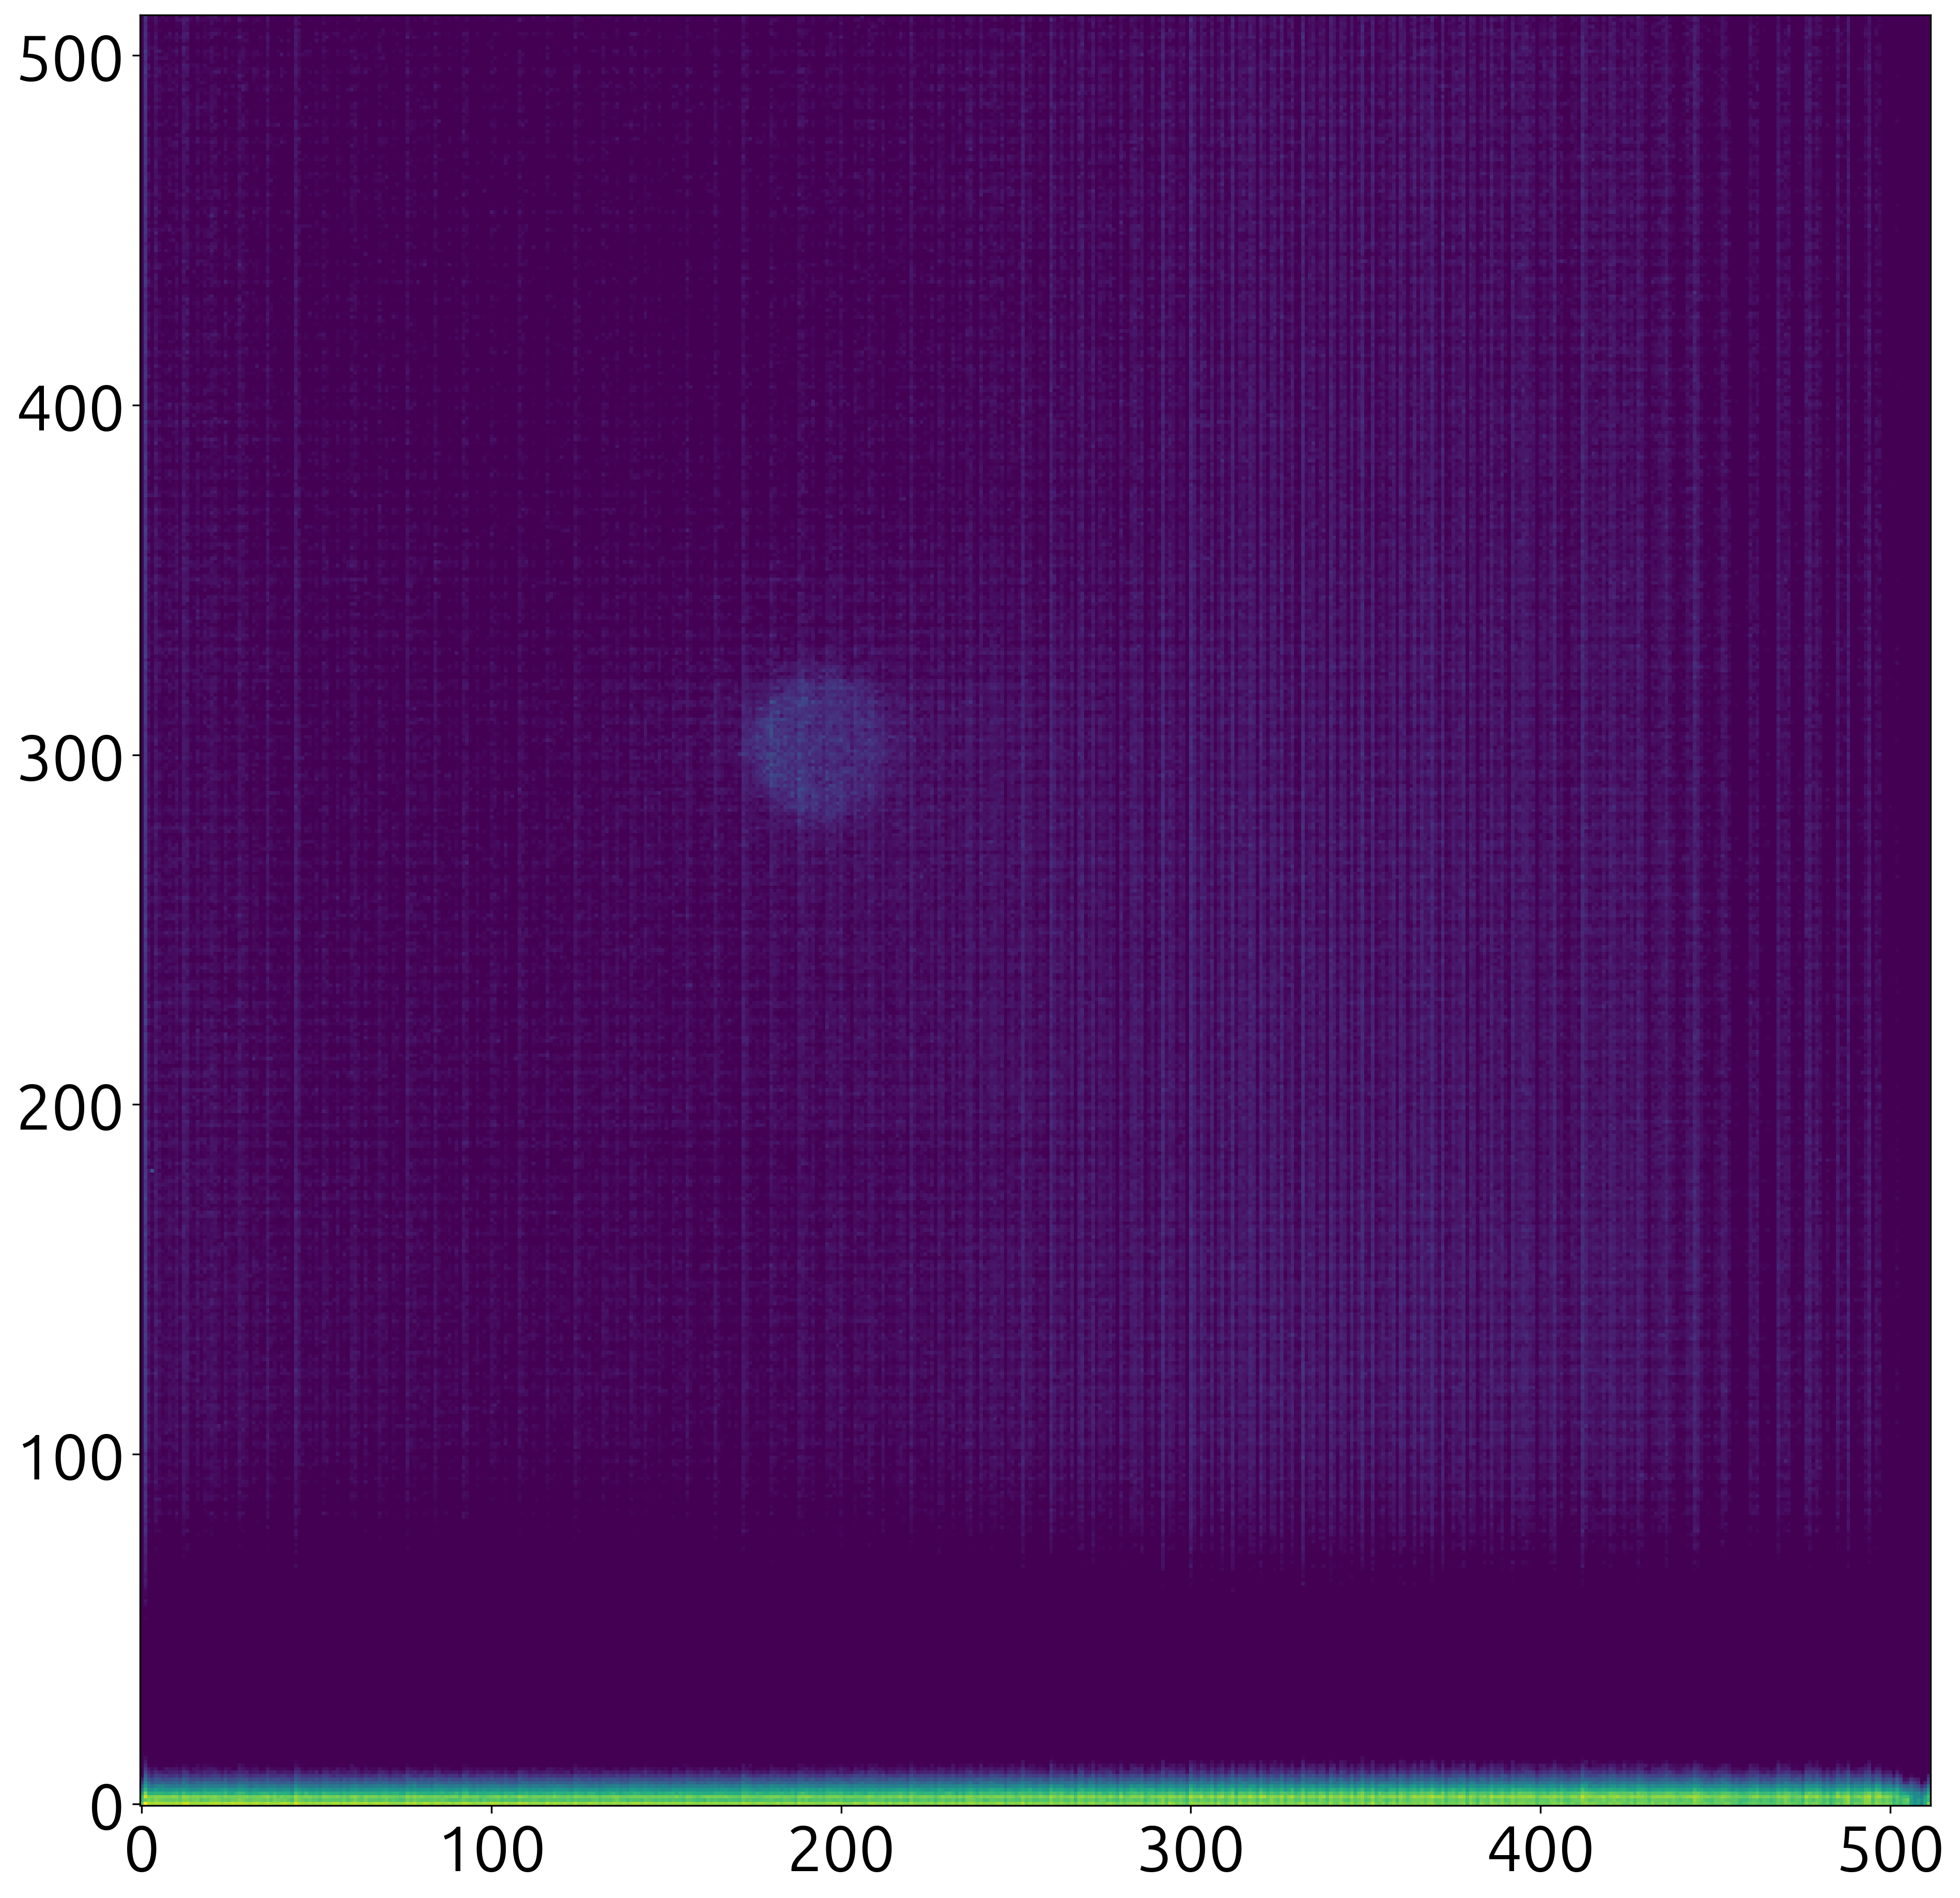

In [18]:
plt.figure(figsize=(15,15),dpi=300)
plt.imshow(AveragedImages,origin="lower",vmin=np.mean(AveragedImages),vmax=np.max(AveragedImages))
plt.show()

In [ ]:
PixelShape=(512,512)
Needle14cmMask=MaskCreate((PixelShape),50,(215,270))

Needle9cmMask=MaskCreate(PixelShape,50,(309,306))

Needle4cmMask=MaskCreate(PixelShape,50,(261,180))

In [ ]:
Values={"4cm":np.array([]),"9cm":np.array([]),"14cm":np.array([]),"4cm_cut":np.array([]),"9cm_cut":np.array([]),"14cm_cut":np.array([])}
for i in Images:
    Values["4cm"]=np.append(Values["4cm"],np.mean(Images[i][Needle4cmMask[0]]))
    Values["9cm"]=np.append(Values["9cm"],np.mean(Images[i][Needle9cmMask[0]]))
    Values["14cm"]=np.append(Values["14cm"],np.mean(Images[i][Needle14cmMask[0]]))
        
    

    

In [ ]:
binss=np.arange(np.min(Values["14cm"]),np.max(Values["4cm"]),5)

plt.figure(figsize=(15,15),dpi=300)
plt.title("Intensity Distribution")
plt.hist(Values["4cm"],label="4cm",bins=binss,alpha=0.8)
plt.hist(Values["9cm"],label="9cm",bins=binss,alpha=0.8)
plt.hist(Values["14cm"],label="14cm",bins=binss,alpha=0.3)
#plt.vlines(2150,0,1200)
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.legend()
plt.show()

In [ ]:
print(f"Amount of Images is {len(AveragedImages)}")

In [ ]:
ValuesA={"4cm":np.array([]),"9cm":np.array([]),"14cm":np.array([])}
for i in AveragedImages:
    ValuesA["4cm"]=np.append(ValuesA["4cm"],np.mean(i[Needle4cmMask[0]]))
    ValuesA["9cm"]=np.append(ValuesA["9cm"],np.mean(i[Needle9cmMask[0]]))
    ValuesA["14cm"]=np.append(ValuesA["14cm"],np.mean(i[Needle14cmMask[0]]))


In [ ]:
    
binss=np.arange(np.min(ValuesA["14cm"]),np.max(ValuesA["4cm"]),5)
plt.figure(figsize=(15,15),dpi=300)
plt.title("Intensity Distribution for AverageImages")
plt.hist(ValuesA["4cm"],label="4cm",bins=binss,alpha=0.8)
plt.hist(ValuesA["9cm"],label="9cm",bins=binss,alpha=0.8)
plt.hist(ValuesA["14cm"],label="14cm",bins=binss,alpha=0.8)
plt.xlabel("Intensity")
plt.ylabel("Counts")
plt.legend()
plt.show()
    

In [ ]:
theAvrI=AvergImage(Images,200,Single=True)

In [ ]:
plt.imshow((theAvrI*Needle4cmMask[0])+(theAvrI*Needle9cmMask[0])+(theAvrI*Needle14cmMask[0]),origin="lower")

In [ ]:
plt.figure(figsize=(15,15),dpi=300)
xx=np.arange(0,len(Values["4cm"]),1)

plt.scatter(xx,Values["4cm"],s=1,label="4cm")
plt.xlabel("Images")
plt.ylabel("Intensity")
plt.show()
plt.figure(figsize=(15,15),dpi=300)
plt.scatter(xx,Values["9cm"],s=1,label="9cm")
plt.show()
plt.figure(figsize=(15,15),dpi=300)
plt.scatter(xx,Values["9cm"],s=1,label="9cm")
plt.show()


